# Checking broadband data

In [69]:
import ooipy
import numpy as np
import obspy
from datetime import datetime
import kaooi
import xarray as xr
from matplotlib import pyplot as plt

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
ooipy.__version__

'1.2.1.dev16'

In [12]:
%%time
node='LJ01C'
starttime = datetime(2024,1,2,0)
endtime = datetime(2024,1,2,2)

hdata = ooipy.get_acoustic_data(starttime, endtime, node, verbose=True)

Fetching URLs...
Sorting valid URLs for Time Window...


100%|███████████████████████████████████████████| 26/26 [00:21<00:00,  1.19it/s]


Merging Data...
number of traces: 1078
merging segments...
number of new segments 33
merging merged segments...
merging with 4 cores
Data has Gaps
CPU times: user 1min 31s, sys: 1min 43s, total: 3min 14s
Wall time: 3min 16s


In [21]:
fn = '/datadrive/kauai/transmissions/ooi_bb/20230318T000000.nc'

ds = xr.open_dataset(fn)

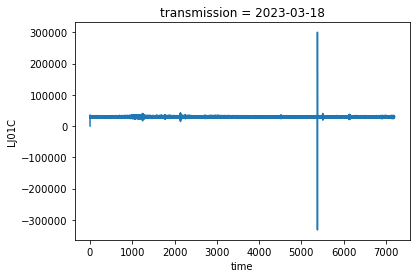

In [24]:
ds['LJ01C'].plot()

In [32]:
Tx_times = kaooi.get_Tx_keytimes(2023)
kaooi.downloadTx_64kHz(Tx_times[0], length='10M', verbose=True, nodes=['LJ01C'], ds_dir = '~/Code/kaooi/dev_notebooks/')

LJ01C:
Fetching URLs...
Sorting valid URLs for Time Window...


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


Merging 4 Traces...
20230318T000000 completed.


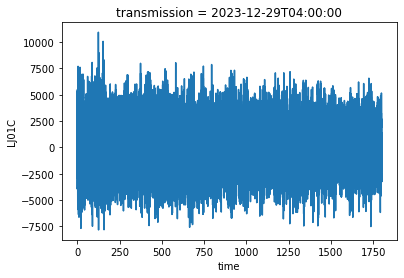

In [111]:
fn = '/datadrive/kauai/transmissions/ooi_bb/LJ01C/20231229T040000.nc'
xr.open_dataset(fn)['LJ01C'].plot()

In [125]:
import h5py
fn = '/datadrive/kauai/transmissions/ooi_bb/LJ01C/20230318T040000.nc'

xr.open_dataarray(fn)

<xarray.DataArray 'LJ01C' (time: 3600001, transmission: 1)>
[3600001 values with dtype=float64]
Coordinates:
  * transmission  (transmission) datetime64[ns] 2023-03-18T04:00:00
  * time          (time) float64 0.0 0.002 0.004 ... 7.2e+03 7.2e+03 7.2e+03
Attributes: (12/13)
    sampling_rate:  500.0
    delta:          0.002
    starttime:      2023-03-18T04:00:00.000000Z
    endtime:        2023-03-18T06:00:00.000000Z
    npts:           3600001
    calib:          1.0
    ...             ...
    station:        HYEA1
    location:       LJ01C
    channel:        YDH
    mseed:          AttribDict({'dataquality': 'D', 'number_of_records': 9255...
    _format:        MSEED
    processing:     ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2023, 3, 18, 6, 0...

In [98]:
st = obspy.read('https://rawdata-west.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2023/12/25/OO-HYEA1--YDH-2023-12-25T00:00:00.000000Z.mseed')

In [99]:
st_all = st[:10].merge()

In [100]:
# remove mean
st_all[0].data = st_all[0].data - np.mean(st_all[0].data)

In [101]:
# fill gaps with zeros
st_all[0].data = st_all[0].data.filled(fill_value=0)

In [102]:
st_all.decimate(16).decimate(8)

1 Trace(s) in Stream:
OO.HYEA1..YDH | 2023-12-25T00:00:00.000000Z - 2023-12-25T00:00:04.458000Z | 500.0 Hz, 2230 samples

In [110]:
Tx_times[-10:]

[Timestamp('2023-11-23 08:00:00'),
 Timestamp('2023-11-23 12:00:00'),
 Timestamp('2023-11-23 16:00:00'),
 Timestamp('2023-11-23 20:00:00'),
 Timestamp('2023-11-27 00:00:00'),
 Timestamp('2023-11-27 04:00:00'),
 Timestamp('2023-11-27 08:00:00'),
 Timestamp('2023-11-27 12:00:00'),
 Timestamp('2023-11-27 16:00:00'),
 Timestamp('2023-11-27 20:00:00')]

## Let's play around with kerchunk for a bit to see where we get

In [38]:
import fsspec
import xarray as xr
import kerchunk
from kerchunk.hdf import SingleHdf5ToZarr
import zarr
import dask

In [39]:
fs = fsspec.filesystem('')

In [40]:
f_list = fs.glob('/datadrive/kauai/transmissions/ooi_bb/LJ01C/*.nc')[:3]

In [41]:
singles = []
for f in f_list:
    infile = fs.open(f)
    h5chunks = SingleHdf5ToZarr(infile, f)
    
    singles.append(h5chunks.translate())

In [42]:
storage_options = {
    'fo':singles[0],
}

z = zarr.open("reference://", storage_options=storage_options)

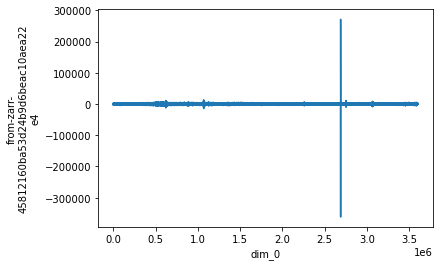

In [49]:
xr.DataArray(dask.array.from_zarr(z['LJ01C'])).plot()

In [51]:
singles[0]

{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  'LJ01C/.zarray': '{"chunks":[3600001,1],"compressor":null,"dtype":"<f8","fill_value":"NaN","filters":null,"order":"C","shape":[3600001,1],"zarr_format":2}',
  'LJ01C/.zattrs': '{"_ARRAY_DIMENSIONS":["time","transmission"],"_format":"MSEED","calib":1.0,"channel":"YDH","delta":0.002,"endtime":"2023-03-18T02:00:00.000000Z","location":"LJ01C","mseed":"AttribDict({\'dataquality\': \'D\', \'number_of_records\': 8832, \'encoding\': \'STEIM2\', \'byteorder\': \'>\', \'record_length\': 4096, \'filesize\': 36175872})","network":"OO","npts":3600001,"processing":"[\'ObsPy 1.4.0: trim(endtime=UTCDateTime(2023, 3, 18, 2, 0)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2023, 3, 18, 0, 0))\', \\"ObsPy 1.4.0: filter(options={\'freq\': 4000.0, \'maxorder\': 12}::type=\'lowpass_cheby_2\')\\", \'ObsPy 1.4.0: decimate(factor=8::no_filter=False::strict_length=False)\', \\"ObsPy 1.4.0: filter(options={\'freq\': 500.0, \'max